In [ ]:
from typing import List, Tuple
import numpy as np

from drawing import draw_lines


def cross_product2d(a: np.ndarray, b: np.ndarray) -> np.ndarray:
  if a.shape[0] == 0 or b.shape[0] == 0:
    return np.zeros(0)
  return a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]

class Sim:
  def __init__(
    self,
    positions: np.ndarray,
    segments: List[Tuple[int, int, int]],  # center of mass, render point 1, render point 2
    connections: List[Tuple[int, int, int]],
    collision_points: List[Tuple[int, int]]  # segment, point
  ):
    self.origins = np.stack([positions[origin] for origin, _, __ in segments])
    self.velocities = np.zeros((len(segments), 2))
    self.angles = np.zeros(len(segments))
    self.angular_velocities = np.zeros(len(segments))
    
    connections = np.array(connections, dtype=np.long)
    self.connections = connections[:, :2]
    self.connection_points1 = positions[connections[:, 2]] - self.origins[connections[:, 0]]
    self.connection_points2 = positions[connections[:, 2]] - self.origins[connections[:, 1]]
    
    self.render_points1 = positions[[pos1 for _, pos1, __ in segments]] - self.origins
    self.render_points2 = positions[[pos2 for _, __, pos2 in segments]] - self.origins
    
    self.collision_segments = np.array([segment for segment, _ in collision_points], dtype=np.long)
    self.collision_points = positions[[point for _, point in collision_points]] - self.origins[self.collision_segments]

  def step(self):
    masses = 1
    moments_of_inertia = 1

    rotation_matrices = self._rotation_matrices()
    connection_points1 = np.matmul(rotation_matrices[self.connections[:, 0]], self.connection_points1[:, :, None]).squeeze(-1)
    connection_points2 = np.matmul(rotation_matrices[self.connections[:, 1]], self.connection_points2[:, :, None]).squeeze(-1)
    connection_discrepancy = (
      (connection_points2 + self.origins[self.connections[:, 1]])
      - (connection_points1 + self.origins[self.connections[:, 0]])
    )
    # connection restoring forces
    force_vectors1 = 1 * np.linalg.norm(connection_discrepancy, axis=-1) * connection_discrepancy
    force_vectors2 = -force_vectors1

    total_linear_forces = np.zeros((len(self.origins), 2))
    np.add.at(total_linear_forces, self.connections[:, 0], force_vectors1)
    np.add.at(total_linear_forces, self.connections[:, 1], force_vectors2)

    total_angular_forces = np.zeros(len(self.origins))
    np.add.at(total_angular_forces, self.connections[:, 0], cross_product2d(connection_points1, force_vectors1))
    np.add.at(total_angular_forces, self.connections[:, 1], cross_product2d(connection_points2, force_vectors2))

    # angular damping
    total_angular_forces -= 0.1 * np.abs(self.angular_velocities) * self.angular_velocities

    collision_points = np.matmul(rotation_matrices[self.collision_segments], self.collision_points[:, :, None]).squeeze(-1)
    
    # v = vo + w x r = [fx / m, fy / m] + (rx * fy - ry * fx) / I * [-ry, rx]
    # va = vo + w x r = [vox, voy] + w * [-ry, rx]
    # vay = voy + w * rx
    # vx = fx / m - (rx * fy - ry * fx) / I * ry
    # vy = fy / m + (rx * fy - ry * fx) / I * rx
    # vy = fy / m + rx^2 * fy / I
    # vy = fy * (1 / m + rx^2 / I)
    # fy = -vay / (1 / m + rx^2 / I)
    # --- # fx = min(vx * m, fy * .2)
    # vo = f / m, w = r x f / I = (rx * fy - ry * fx) / I
    distance_below_ground = np.clip(-2 - (collision_points + self.origins[:, self.collision_segments])[:, 1], min=0)
    colliding_with_ground = distance_below_ground > 0
    segments_colliding = self.collision_segments[colliding_with_ground]
    collision_point_velocity = self.velocities[segments_colliding, 1] + self.angular_velocities[segments_colliding] * self.collision_points[colliding_with_ground, 0]
    segments_colliding = collision_point_velocity < 0


    fy = -collision_point_velocity / (1 / masses + np.square(self.collision_points[colliding_with_ground, 0]) / moments_of_inertia)
    fy = fy[segments_colliding]
    

    
    # print(fy.shape)
    collision_forces = np.stack((np.zeros_like(fy), fy), axis=-1)
    # ground_restoring_force = np.clip(0.001 * np.stack((np.zeros(collision_points.shape[0]), distance_below_ground), axis=-1), max=0.0001)
    np.add.at(total_linear_forces, segments_colliding, collision_forces)
    np.add.at(total_angular_forces, segments_colliding, cross_product2d(collision_points, collision_forces))
    self.origins[segments_colliding, 1] += distance_below_ground[segments_colliding]

    self.velocities += total_linear_forces / masses
    self.angular_velocities += total_angular_forces / moments_of_inertia
    self.origins += self.velocities
    self.angles += self.angular_velocities

  def render(self, origin: Tuple[float, float], resolution: Tuple[int, int], pixels_per_unit: float) -> np.ndarray:
    rotation_matrices = self._rotation_matrices()
    points1 = np.matmul(rotation_matrices, self.render_points1[:, :, None]).squeeze(-1) + self.origins
    points2 = np.matmul(rotation_matrices, self.render_points2[:, :, None]).squeeze(-1) + self.origins

    def cvt(points: np.ndarray):
      points = (points - origin) * pixels_per_unit
      points[:, 1] *= -1
      points = np.flip(points, axis=-1)
      points += np.array(resolution) / 2
      return points

    canvases = np.zeros((1, *resolution))
    draw_lines(canvases, cvt(np.array([[-5.0, -2.0]])), cvt(np.array([[5.0, -2.0]])), sample_count=200, width=0.5, width_pass_count=4)
    for start, end in zip(cvt(points1), cvt(points2)):
      draw_lines(canvases, start[None, :], end[None, :], sample_count=100, width=0.5, width_pass_count=4)
    return canvases[0]

  def _rotation_matrices(self) ->  np.ndarray:
    rotation_matrices = np.zeros((len(self.origins), 2, 2))
    rotation_matrices[:, 0, 0] = np.cos(self.angles)
    rotation_matrices[:, 1, 0] = np.sin(self.angles)
    rotation_matrices[:, 0, 1] = -np.sin(self.angles)
    rotation_matrices[:, 1, 1] = np.cos(self.angles)
    return rotation_matrices

    
sim = Sim(
  positions=np.array([[-2.0, 0.0], [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [2.0, 0.0]]),
  segments=[(1, 0, 2), (3, 2, 4)],
  connections=[(0, 1, 2)],
  collision_points=[(0, 0), (1, 4)]
)
print(sim.connection_points1, sim.connection_points2)

[[1. 0.]] [[-1.  0.]]


In [18]:
# sim.origins[0] = np.array([-0.9, 1.0])
import matplotlib.pyplot as plt
print('origins:', sim.origins)
print('angles:', sim.angles)

sim.step()
plt.imshow(sim.render((0, 0), (100, 100), 10))

origins: [[-1.  0.]
 [ 1.  0.]]
angles: [0. 0.]


In [13]:
sim = Sim(
  positions=np.array([[-2.0, 0.0], [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [2.0, 0.0]]),
  segments=[(1, 0, 2), (3, 2, 4)],
  connections=[(0, 1, 2)],
  collision_points=[(0, 0), (1, 4)]
)
sim.angular_velocities[0] = 0.01
sim.angular_velocities[1] = -0.01
# sim.velocities[0] = np.array([0.01, 0.01])

In [2149]:
import time
import cv2
cv2.imshow('Image', sim.render((0, 0), (100, 100), 10))

space_pressed = False
last_call_time = 0
interval = 0.02
while True:
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord(' '):  # Space bar pressed
        space_pressed = True
    elif key == 255:  # No key pressed
        space_pressed = False
    
    # Call handler repeatedly while space is held down
    if space_pressed:
        current_time = time.time()
        if current_time - last_call_time >= interval:
            for _ in range(10):
              sim.velocities[:, 1] -= 0.0001
              sim.step()
            cv2.imshow('Image', sim.render((0, 0), (100, 100), 10))
            last_call_time = current_time
    
    if key == ord('q'):  # Press 'q' to quit
        break
cv2.waitKey(0)
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [19]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

sim = Sim(
  positions=np.array([[-2.0, 0.0], [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [2.0, 0.0]]),
  segments=[(1, 0, 2), (3, 2, 4)],
  connections=[(0, 1, 2)],
  collision_points=[(0, 0), (1, 4)]
)
# sim.angular_velocities[0] = 0.01
# sim.angular_velocities[1] = -0.01
# sim.velocities[0] = np.array([0.01, 0.01])

# Create a sample image (replace with your image loading)
fig, ax = plt.subplots()
im = ax.imshow(sim.render((0, 0), (100, 100), 10))
ax.axis('off')

space_pressed = False
interval_ms = 50  # Update interval in milliseconds

def on_key_press(event):
    global space_pressed
    if event.key == ' ':
        space_pressed = True

def on_key_release(event):
    global space_pressed
    if event.key == ' ':
        space_pressed = False

def update(frame):
    if space_pressed:
        # TODO: Add your image change logic here
        for _ in range(100):
          sim.velocities[:, 1] -= 0.00001
          sim.step()
        im.set_data(sim.render((0, 0), (100, 100), 10))
        # Example: im.set_data(new_image)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('key_press_event', on_key_press)
fig.canvas.mpl_connect('key_release_event', on_key_release)

ani = FuncAnimation(fig, update, interval=interval_ms, blit=False, cache_frame_data=False)

plt.show()

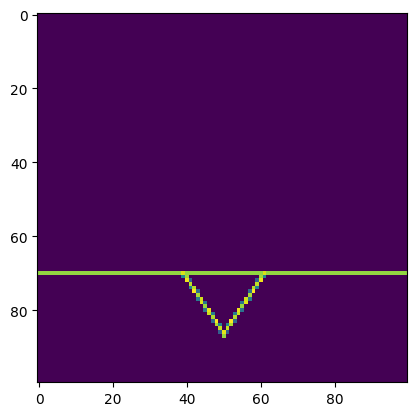

In [2140]:
for _ in range(10):
  sim.velocities[:, 1] -= 0.0001
  sim.step()
plt.imshow(sim.render((0, 0), (100, 100), 10))